In [1]:
import numpy as np
import pandas as pd

from scipy.fft import rfft

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.grid'] = False

## 数据处理

In [2]:
# 从第五行开始, 每六条记录选中一条
df = pd.read_csv('jena_climate_2009_2016.csv')[5::6]
df.index = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

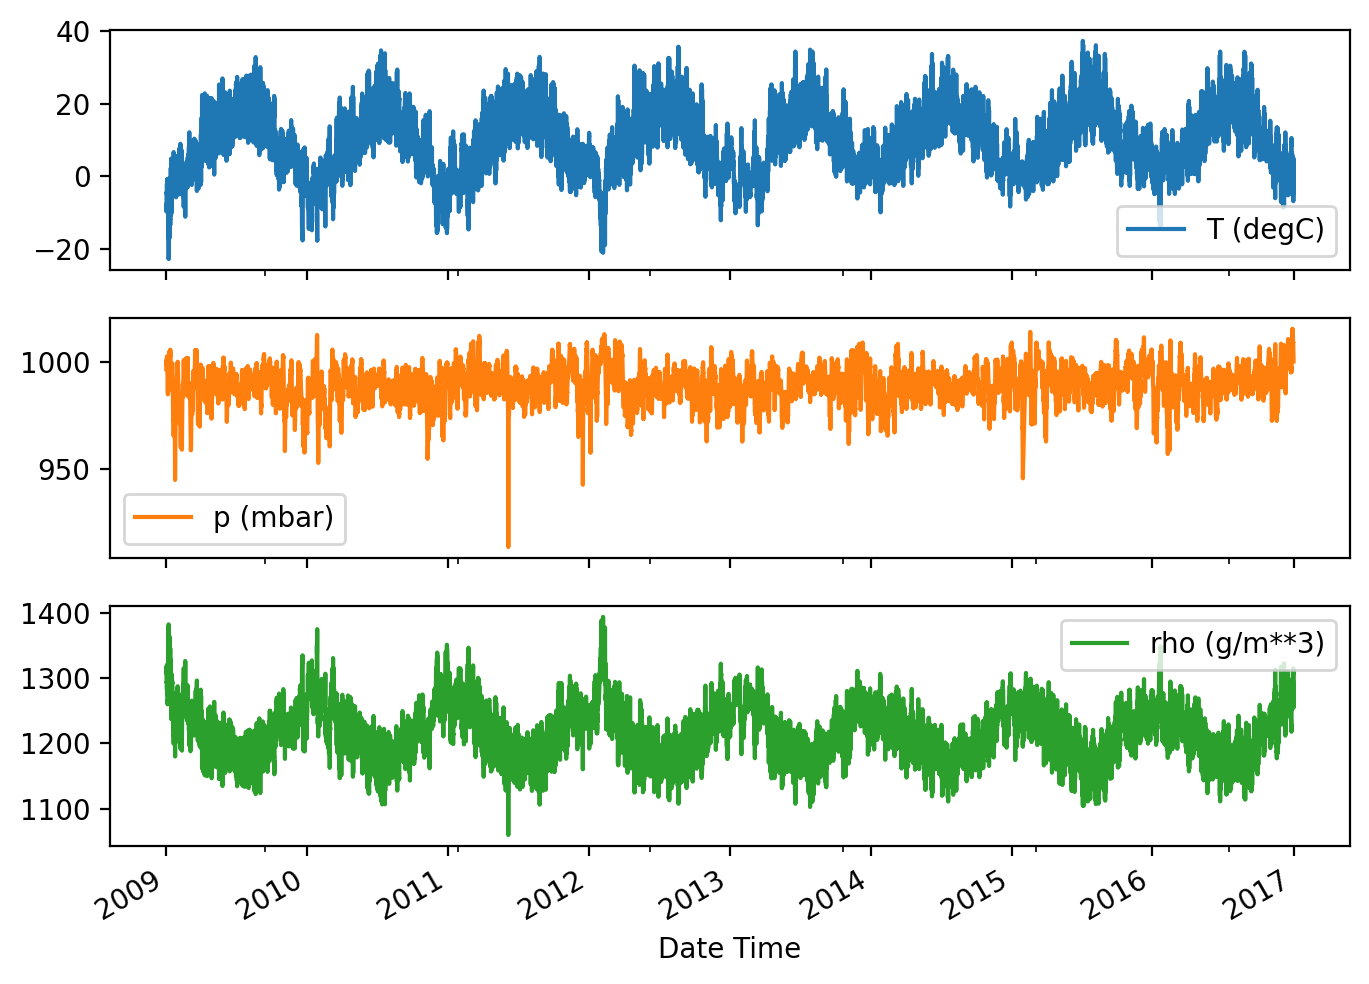

In [3]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.plot(subplots=True)

array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

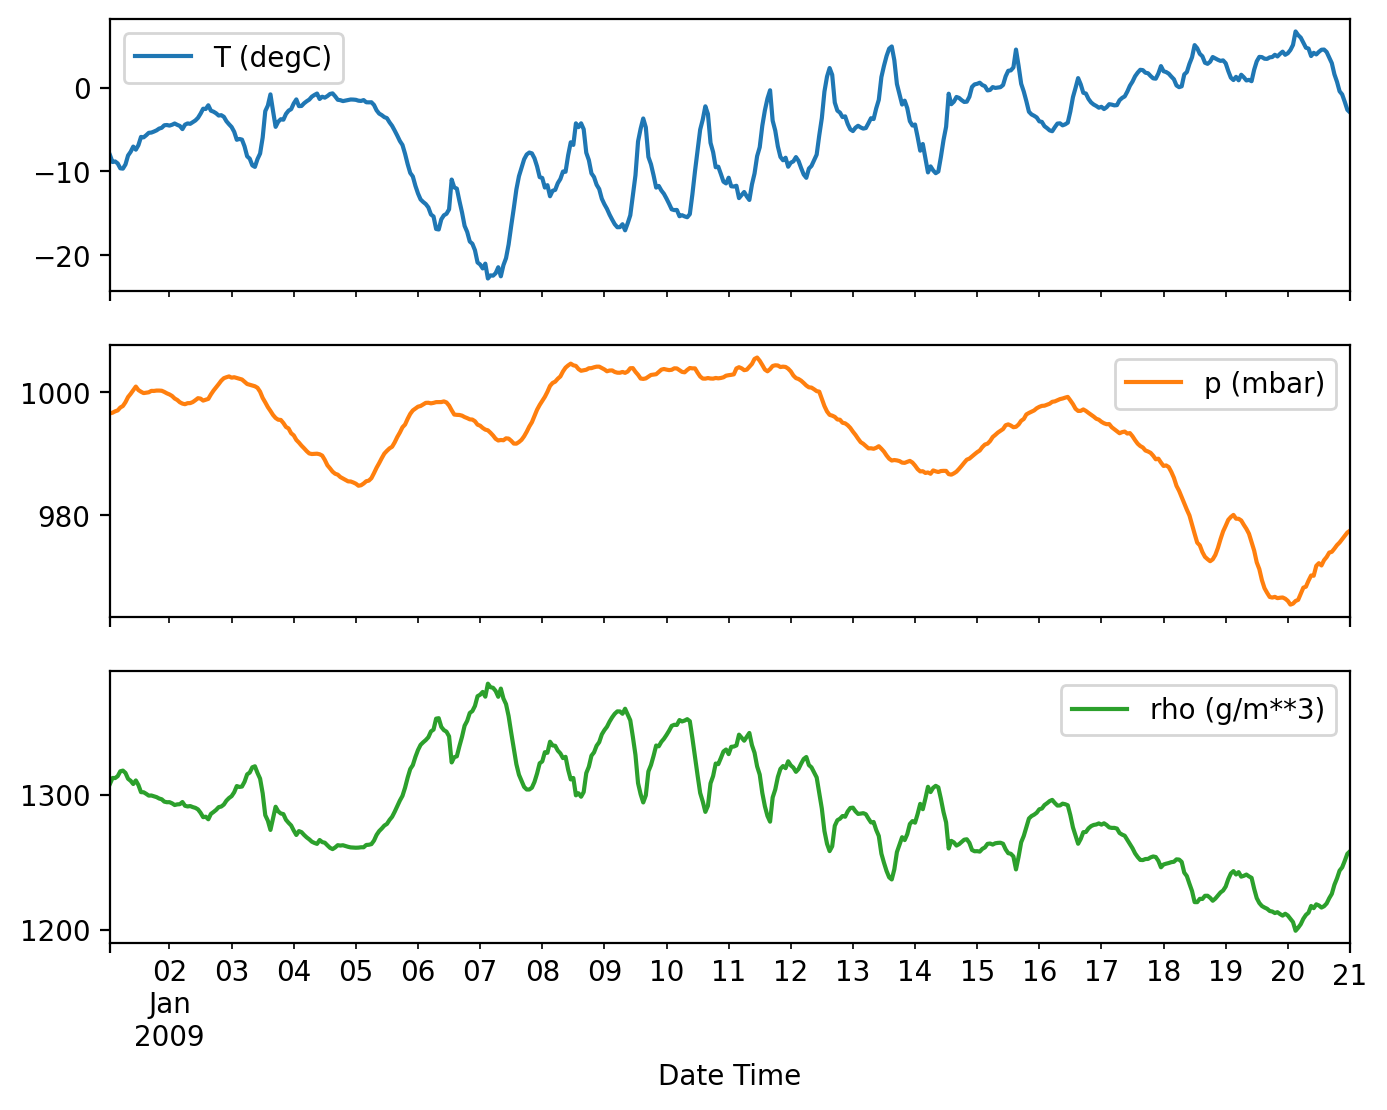

In [4]:
plot_features = df[plot_cols][: 480]
plot_features.plot(subplots=True)

## 查看并清理数据

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


可见风速和最大风速的最小值都是-9999, 可能是个错误值, 故直接用0替换掉它.

In [6]:
df['wv (m/s)'] = df['wv (m/s)'].clip(lower=0)
df['max. wv (m/s)'] = df['max. wv (m/s)'].clip(lower=0)

## 特征工程

### 风

数据表格的最后一列是以角度为单位的风向。角度对模型来说并不是一个好的输入：0° 和 360° 在数值上差很多，但在几何上应该非常接近且可以平滑过渡。另外无风时（风速为零）风向不应该起作用。

风向和风速的联合分布如下:

Text(0, 0.5, 'Wind Velocity [m/s]')

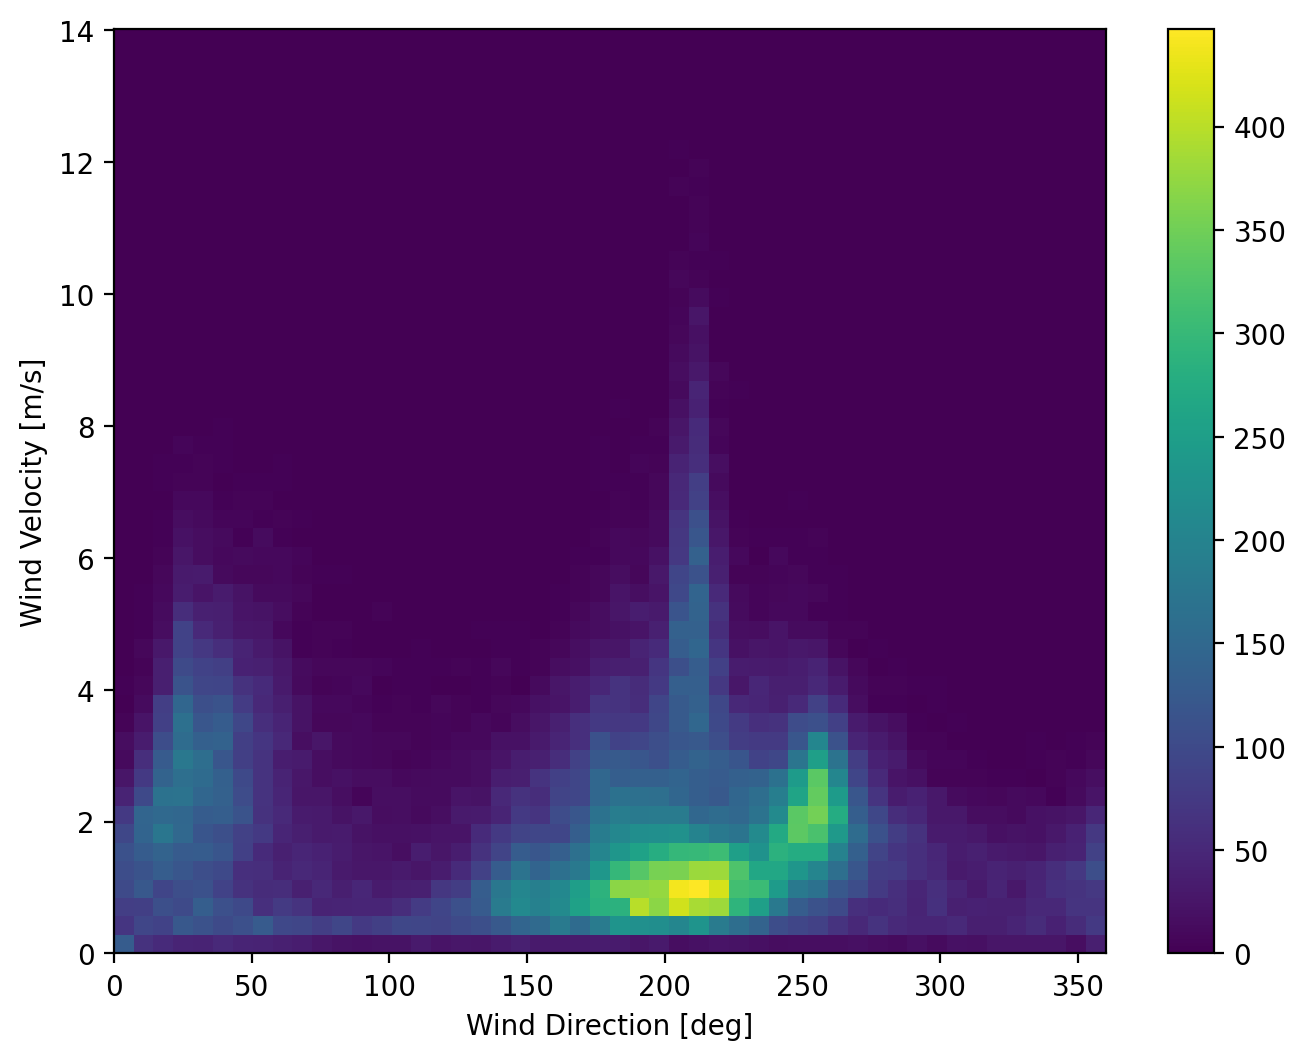

In [7]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50))
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

更好的解读方式是把风向和风速转变为风矢量:

In [8]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

wd_rad = np.deg2rad(270 - df.pop('wd (deg)'))

df['Wx'] = wv * np.cos(wd_rad)
df['Wy'] = wv * np.sin(wd_rad)

(-7.733831295546779, 8.27438540335515, -8.244699285490789, 11.305513973134666)

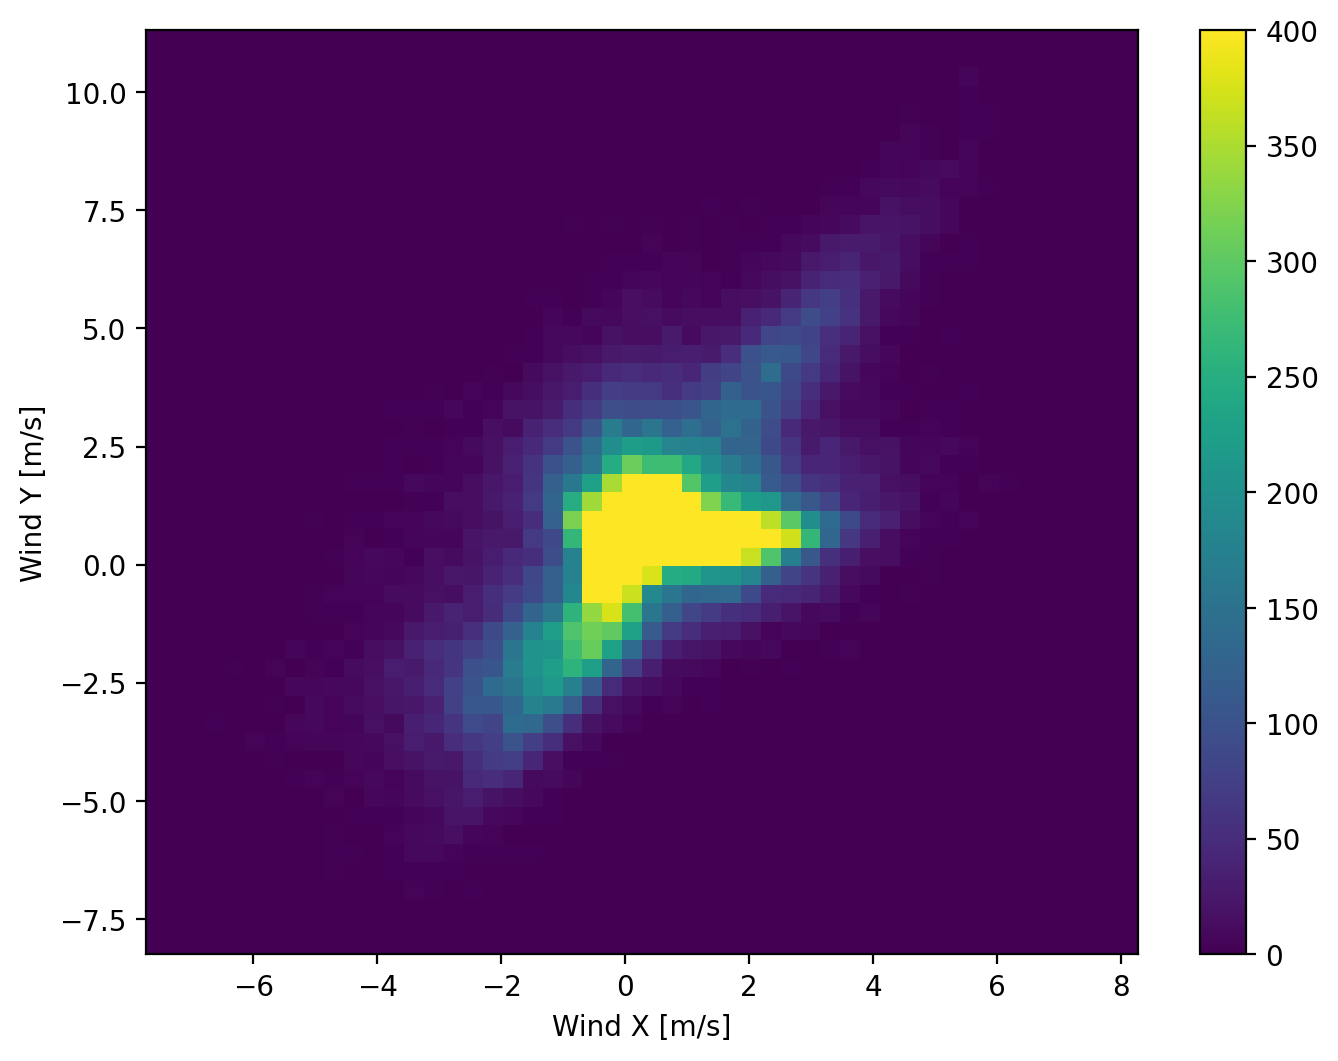

In [9]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmin=0, vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
plt.axis('tight')

### 时间

首先将时间都转换成秒:

In [10]:
timestamp_s = df.index.map(pd.Timestamp.timestamp)

和风向的情况类似, 以秒表示的时间对模型来说没什么用. 我们看到天气数据存在明显的以日和年为单位的周期性, 故我们可以用余弦和正弦函数表示这些周期信号:

In [11]:
day = 24 * 60 * 60
year = 365.2425 * day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

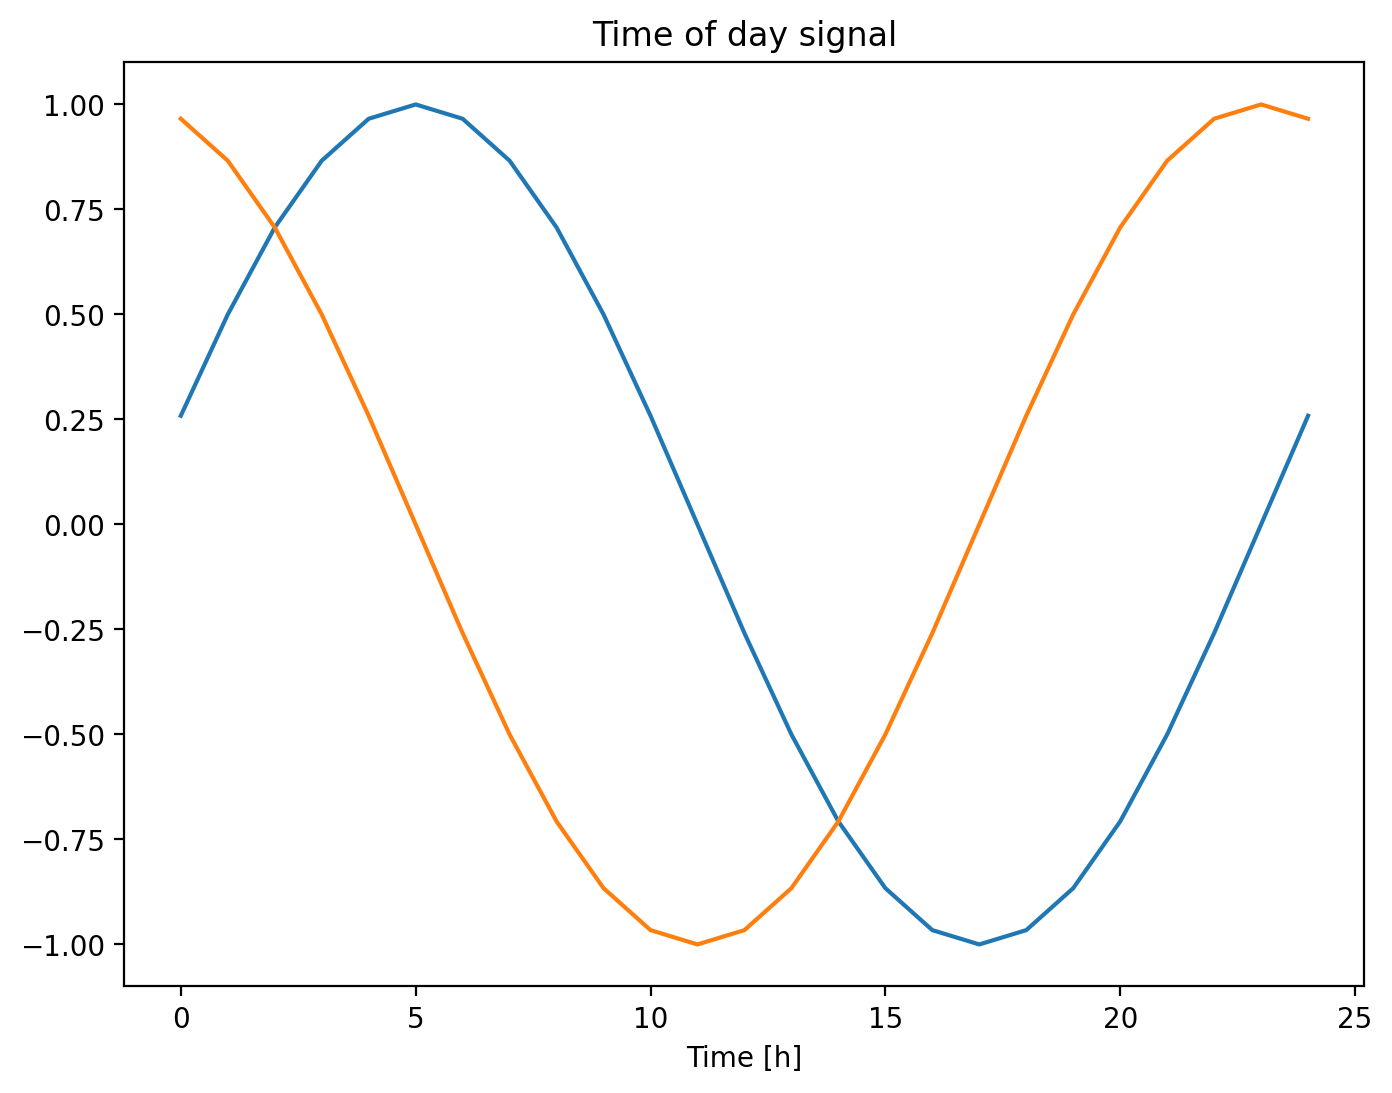

In [12]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

这就给模型提供了重要的频率特征. 不过这些频率特征不是下确定的, 我们需要提前确定哪些频率是重要的. 如果我们不确定, 可以使用快速傅里叶变换来找出这些频率.

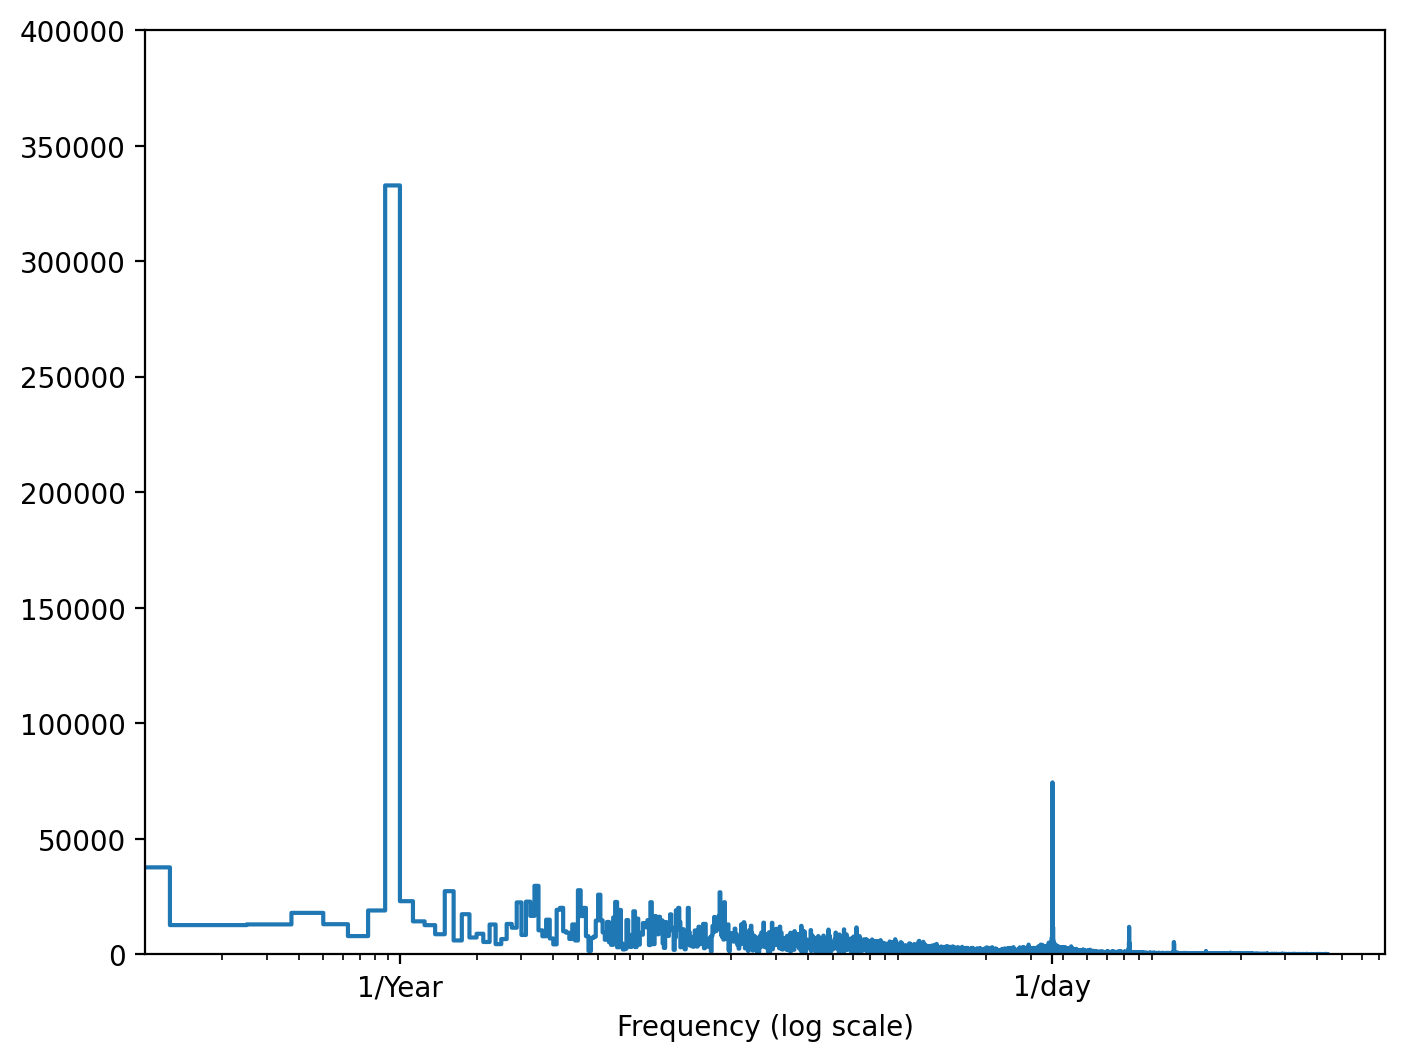

In [13]:
fft = rfft(df['T (degC)'].to_numpy())
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24 * 365.2524
years_per_dataset = n_samples_h / hours_per_year

f_per_year = f_per_dataset / years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

可见图中`1/year`和`1/day`处出现了明显峰值.

### 数据划分

我们用70%, 20%, 10%的比例划分训练集, 验证集和测试集. 在划分完成前不要打乱数据, 原因有二:
1. 保证后续可以将数据切成许多由连续样本构成的窗口
2. 保证用于评估的验证机和测试集实在模型训练完后收集的, 使评估结果更符合实际情况

In [14]:
n = len(df)
i1 = int(n * 0.7)
i2 = int(n * 0.9)
train_df = df.iloc[: i1]
val_df = df.iloc[i1: i2]
test_df = df.iloc[i2: ]

num_features = df.shape[1]

### 标准化数据

In [15]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

我们现在看一眼所有特征的分布

C:\Users\miaoy\AppData\Local\Temp\ipykernel_35888\3214313372.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


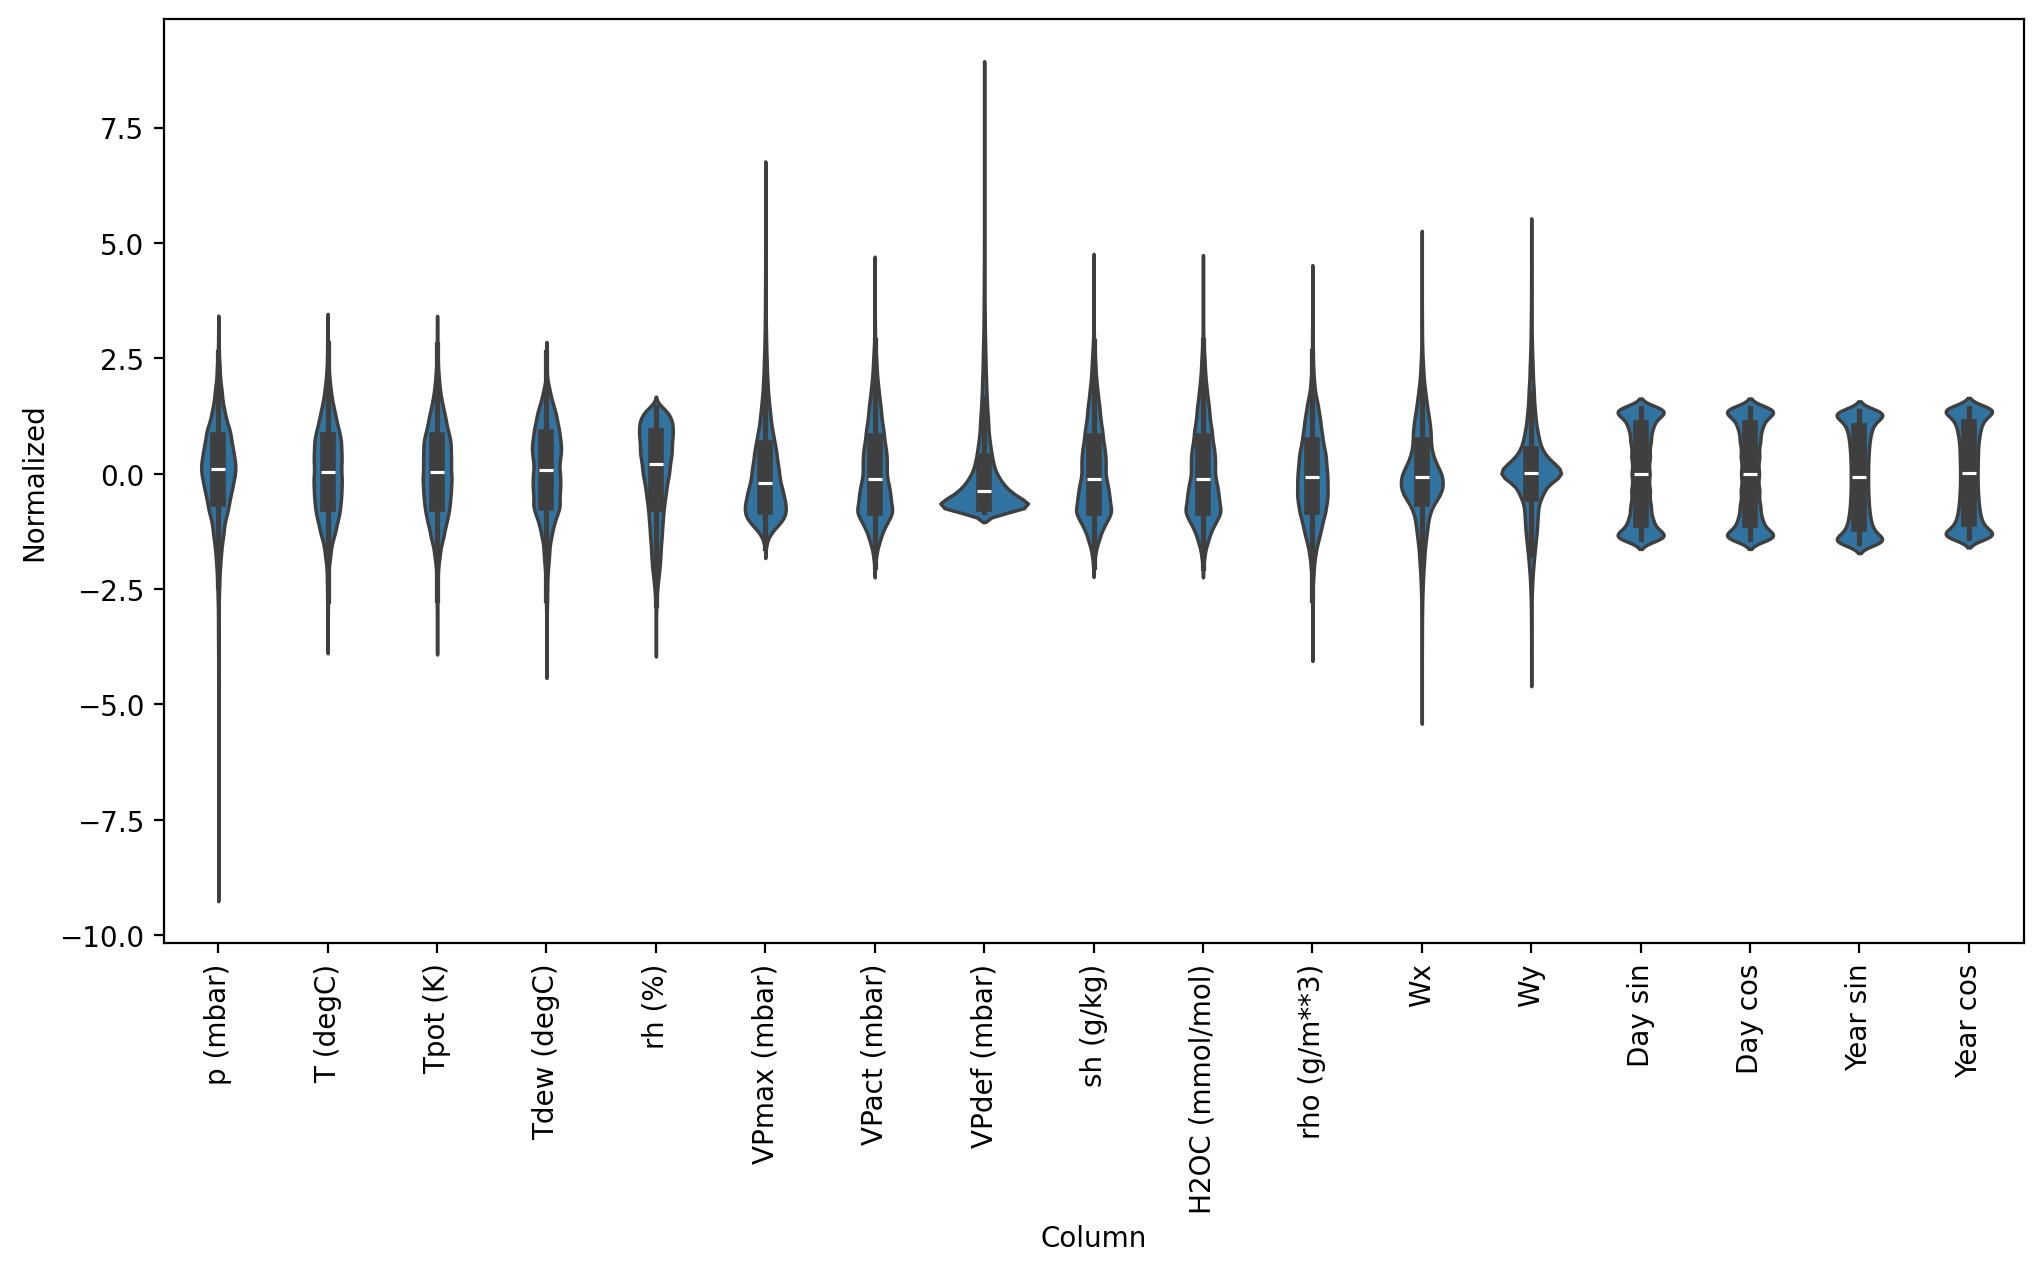

In [16]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)